## 1. Library Imports


In this section, we import all the necessary libraries for data preprocessing, tokenization, model training, and evaluation.


In [1]:
import pandas as pd
import random
from typing import List, Tuple, Dict, Any
from transformers import BertTokenizer, BertForMaskedLM, BertForPreTraining, PreTrainedTokenizer, get_linear_schedule_with_warmup
import nltk
from nltk.tokenize import sent_tokenize
from tqdm import tqdm  
import torch
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import time
import matplotlib.pyplot as plt
import os
import yaml
import ast
import json 

nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to /home/carmine-
[nltk_data]     landolfi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Preparation of dataset to compute DAPT



To prepare the dataset for NSP, for each abstract, we generate two sentence pairs used in the Next Sentence Prediction (NSP) task.

- **Positive pairs (label 0)**: Two consecutive sentences from the same abstract.
- **Negative pairs (label 1)**: Two non-consecutive sentences (from the same abstract or different abstracts).

This setup simulates the original NSP objective from BERT’s pre-training, where the model learns to predict whether a given sentence B logically follows sentence A.

The sentence pairs are tokenized using the BERT tokenizer. We apply the following settings:

- `sentence_a`, `sentence_b`: the input sentence pairs.
- `return_tensors="pt"`: returns the output as PyTorch tensors.
- `max_length=300`: maximum sequence length accepted by BERT.
- `truncation=True`: truncates longer pairs to fit the model’s limit.
- `padding="max_length"`: ensures all sequences are padded to the same length.

This step converts raw text into model-readable inputs (input IDs, attention masks, and token type IDs) required for pretraining tasks.

To compute tokenizatio e segmentation for MLM the abstracts are first split into sentences and tokenized with BERT’s tokenizer, adding the special tokens `[CLS]` at the start and `[SEP]` at the end of each sentence.

The maximum input length is 512, but due to limited computational power all abstracts longer than 300 were excluded, and the maximum length was set to 300.

Each chunk is padded to the maximum length, and attention masks and token type IDs are created accordingly. The output is a dictionary of tensors ready for input into the BERT model.

In the traditional BERT pre-training procedure, 15% of the tokens are selected for masking. Among those:

- 80% are replaced with the special `[MASK]` token.
- 10% are replaced with a random token from the vocabulary.
- 10% remain unchanged.

This stochastic masking strategy prevents the model from relying too heavily on the presence of `[MASK]` during training, improving its robustness for downstream tasks.



In [2]:
class DataPreparation:
    """
    Prepares data for BERT-style pretraining tasks, including Next Sentence Prediction (NSP)
    and Masked Language Modeling (MLM), from a dataset of text abstracts.

    This class supports creating positive and negative NSP pairs, tokenizing sentence pairs,
    segmenting abstracts into overlapping BERT-compatible chunks, and applying BERT-style token masking.

    Attributes:
        df (pd.DataFrame): DataFrame containing abstracts with a column 'abstract_clean'.
        tokenizer (PreTrainedTokenizer): HuggingFace tokenizer compatible with BERT.
        max_length (int): Maximum token length for BERT inputs.
        mask_prob (float): Probability of masking tokens for MLM.
    """
    def __init__(self, dataframe: pd.DataFrame, tokenizer: PreTrainedTokenizer,
                 max_length: int = 512, mask_prob: float = 0.15):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.mask_prob = mask_prob
        self.masking_stats = {"total_tokens": 0, "masked_tokens": 0}
    
    def tokenize_and_segment_abstracts(self) -> Dict[str, Any]:
        return {
            "input_ids": torch.tensor(self.df["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(self.df["attention_mask"], dtype=torch.long)
        }
        
    def apply_bert_masking(self, features: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """
        Applies BERT-style masking to input features for MLM task and logs masking stats.
    
        Args:
            features (Dict[str, torch.Tensor]): Input dictionary containing 'input_ids'.
    
        Returns:
            Dict[str, torch.Tensor]: Updated input features with masked input and labels.
        """
        input_ids = features["input_ids"]
        masked_input_ids = input_ids.clone()
        labels = input_ids.clone()
        torch.manual_seed(42)
        rand = torch.rand(input_ids.shape)
    
        # Generate masking mask
        mask_arr = (rand < self.mask_prob) & \
                   (input_ids != self.tokenizer.cls_token_id) & \
                   (input_ids != self.tokenizer.sep_token_id) & \
                   (input_ids != self.tokenizer.pad_token_id)
    
        # Count for monitoring
        num_masked = mask_arr.sum().item()
        num_total = ((input_ids != self.tokenizer.cls_token_id) &
                     (input_ids != self.tokenizer.sep_token_id) &
                     (input_ids != self.tokenizer.pad_token_id)).sum().item()
    
        # Update stats
        self.masking_stats["masked_tokens"] += num_masked
        self.masking_stats["total_tokens"] += num_total
    
        labels[~mask_arr] = -100  # only compute loss on masked tokens
    
        for i in range(mask_arr.shape[0]):
            token_indices = torch.nonzero(mask_arr[i]).flatten().tolist()
            for token_idx in token_indices:
                prob = random.random()
                if prob < 0.8:
                    masked_input_ids[i, token_idx] = self.tokenizer.mask_token_id
                elif prob < 0.9:
                    masked_input_ids[i, token_idx] = random.randint(0, self.tokenizer.vocab_size - 1)
    
        features["input_ids"] = masked_input_ids
        features["labels"] = labels
    
        return features


# Creation of Dataset

In [3]:
class CombinedMLMNSPDataset(Dataset):
    """
    A custom PyTorch Dataset that combines data for both Masked Language Modeling (MLM)
    and Next Sentence Prediction (NSP) tasks. Each item returned contains all necessary
    fields for BERT-style pretraining.

    MLM examples will include 'labels' for token prediction and a dummy -100 value for
    'next_sentence_label'. NSP examples will contain 'next_sentence_label' and 'labels'
    filled with -100 to be ignored during MLM loss.

    Args:
        mlm_encodings (Dict[str, torch.Tensor]): Encoded inputs for the MLM task.
            Should include 'input_ids', 'attention_mask', 'token_type_ids', and 'labels'.
        nsp_encodings (Dict[str, torch.Tensor]): Encoded inputs for the NSP task.
            Should include 'input_ids', 'attention_mask', 'token_type_ids', and 'next_sentence_label'.

    Attributes:
        examples (List[Dict[str, torch.Tensor]]): A combined and shuffled list of training examples.
    """
    def __init__(self, mlm_encodings):
        self.examples = []

        # Add MLM examples with dummy -100 NSP label
        for i in range(len(mlm_encodings["input_ids"])):
            self.examples.append({
                "input_ids": mlm_encodings["input_ids"][i].detach().clone(),
                "attention_mask": torch.tensor(mlm_encodings["attention_mask"][i]).detach().clone(),
                "labels": torch.tensor(mlm_encodings["labels"][i]).detach().clone()
            })


    def __len__(self):
        """Returns the total number of combined training examples."""
        return len(self.examples)

    def __getitem__(self, idx):
        """
        Retrieves a single training example at the specified index.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            Dict[str, torch.Tensor]: Dictionary containing:
                - 'input_ids'
                - 'attention_mask'
                - 'token_type_ids'
                - 'labels'
                - 'next_sentence_label'
        """
        return self.examples[idx]


# Training of Model

In this section, we perform the training of the BERT model on both Masked Language Modeling (MLM) and Next Sentence Prediction (NSP) objectives simultaneously.

The training loop in the method  train terates over the dataset in mini-batches, transferring the inputs and labels to the computation device (CPU or GPU). For each batch, it computes the combined loss from both tasks, performs backpropagation, and updates the model parameters using the AdamW optimizer.

The use of the progress bar (via tqdm) allows real-time monitoring of the training process, displaying the current epoch and the loss value to track convergence.

In [4]:
class DAPTTrainer:
    """
    A training utility for Domain-Adaptive Pretraining (DAPT) of BERT using both
    Masked Language Modeling (MLM) and Next Sentence Prediction (NSP) objectives.

    Attributes:
        model (BertForPreTraining): BERT model with MLM + NSP heads.
        dataset (Dataset): PyTorch dataset with combined MLM and NSP data.
        batch_size (int): Batch size used for training.
        epochs (int): Number of full training passes over the dataset.
        lr (float): Learning rate for AdamW optimizer.
        device (torch.device): Training device (CPU or CUDA).
        # checkpoint_dir (str): Directory to store training checkpoints.
        # checkpoint_interval (int): Interval in epochs to save checkpoints.
        dataloader (DataLoader): PyTorch DataLoader for the training dataset.
        optimizer (AdamW): Optimizer used for training.
        scheduler (Scheduler): Learning rate scheduler.
        start_epoch (int): Starting epoch (used when resuming training).
    """

    def __init__(
        self,
        model: BertForPreTraining,
        dataset: Dataset,
        batch_size: int = 16,
        epochs: int = 2,
        lr: float = 1e-5,
        device: torch.device = None,
        resume_from_checkpoint: str = None,  
        plot_save_path: str = None
    ):
        self.model = model
        self.dataset = dataset
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.plot_save_path = plot_save_path

        self.model.to(self.device)
        self.optimizer = AdamW(self.model.parameters(), lr=self.lr)
        self.dataloader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, drop_last=True)

        total_steps = len(self.dataloader) * self.epochs
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=int(0.1 * total_steps),
            num_training_steps=total_steps
        )

        self.start_epoch = 0

        self.model.train()

    
    def evaluate(self, val_dataloader):
        self.model.eval()
        total_loss = 0.0
        count = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)
    
                outputs = self.model(
                    input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                total_loss += outputs.loss.item()
                count += 1
        self.model.train()
        return total_loss / count if count > 0 else float('inf')
        

    def train(self, log_every_n_steps: int = 100, save_loss_path: str = None, val_dataloader=None, val_every_n_steps=500) -> None:
        """
        Training loop con logging della loss ogni 'log_every_n_steps' batch.
        Alla fine salva la lista delle loss su file json se save_loss_path è fornito.
        """

        import time

        self.step_losses = [] 
        self.val_losses = []
        step_loss_accum = 0.0
        step_count = 0

        for epoch in range(self.start_epoch, self.epochs):
            epoch_start = time.time()
            loop = tqdm(self.dataloader, leave=True)
            total_loss = 0.0

            for batch in loop:
                self.optimizer.zero_grad()

                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)

                outputs = self.model(
                    input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                loss = outputs.loss
                loss.backward()
                self.optimizer.step()
                self.scheduler.step()

                loss_item = loss.item()
                total_loss += loss_item
                step_loss_accum += loss_item
                step_count += 1

                if step_count % log_every_n_steps == 0:
                    avg_loss = step_loss_accum / log_every_n_steps
                    self.step_losses.append(avg_loss)
                    print(f"Step {step_count}: Avg Loss {avg_loss:.4f}")
                    step_loss_accum = 0.0


                if val_dataloader is not None and step_count % val_every_n_steps == 0:
                    val_loss = self.evaluate(val_dataloader)
                    print(f"Validation loss after step {step_count}: {val_loss:.4f}")
                    self.val_losses.append(val_loss)


                loop.set_description(f"Epoch {epoch+1}/{self.epochs}")
                loop.set_postfix(loss=loss_item)

            avg_epoch_loss = total_loss / len(self.dataloader)
            epoch_time = time.time() - epoch_start
            print(f"Epoch {epoch+1} completed in {epoch_time:.2f}s - Avg Loss: {avg_epoch_loss:.4f}")

        print("Training finished.")

        if save_loss_path:
            os.makedirs(os.path.dirname(save_loss_path), exist_ok=True)
            # save both train and val loss in a dict
            loss_data = {
                "train_loss": self.step_losses,
                "val_loss": self.val_losses
            }
            with open(save_loss_path, "w") as f:
                json.dump(loss_data, f)
            print(f"Train e Validation loss salvate in {save_loss_path}")

        steps_train = list(range(log_every_n_steps, log_every_n_steps * len(self.step_losses) + 1, log_every_n_steps))
        steps_val = list(range(val_every_n_steps, val_every_n_steps * len(self.val_losses) + 1, val_every_n_steps))

        plt.figure(figsize=(10, 6))
        plt.plot(steps_train, self.step_losses, marker='o', label='Training Loss')
        if self.val_losses:
            plt.plot(steps_val, self.val_losses, marker='x', label='Validation Loss')
        plt.xlabel("Step")
        plt.ylabel("Loss")
        plt.grid(True)
        #plt.title("Training and Validation Loss")
        plt.legend()

        if self.plot_save_path:
            os.makedirs(os.path.dirname(self.plot_save_path), exist_ok=True)
            plt.savefig(self.plot_save_path)
            print(f"Plot saved in {self.plot_save_path}")
        else:
            plt.show()

Some weights of the model checkpoint at ../Models/bert-base-uncased/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594 were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



 Percentage of masked tokens: 15.03% (281492 on 1873118 valid tokens)


/tmp/ipykernel_4133628/2180983160.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(mlm_encodings["attention_mask"][i]).detach().clone(),
/tmp/ipykernel_4133628/2180983160.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "labels": torch.tensor(mlm_encodings["labels"][i]).detach().clone()
Epoch 1/19:  16%|██████████▏                                                     | 100/625 [01:09<06:06,  1.43it/s, loss=2.19]

Step 100: Avg Loss 2.5834


Epoch 1/19:  32%|████████████████████▍                                           | 200/625 [02:19<04:57,  1.43it/s, loss=2.41]

Step 200: Avg Loss 2.4184


Epoch 1/19:  48%|███████████████████████████████▏                                 | 300/625 [03:29<03:47,  1.43it/s, loss=2.1]

Step 300: Avg Loss 2.2949


Epoch 1/19:  64%|████████████████████████████████████████▉                       | 400/625 [04:39<02:37,  1.43it/s, loss=2.25]

Step 400: Avg Loss 2.2143


Epoch 1/19:  80%|███████████████████████████████████████████████████             | 499/625 [05:48<01:28,  1.43it/s, loss=2.06]

Step 500: Avg Loss 2.1839


Epoch 1/19:  80%|████████████████████████████████████████████████▊            | 500/625 [11:45<3:44:12, 107.62s/it, loss=1.92]

Validation loss after step 500: 2.0232


Epoch 1/19:  96%|█████████████████████████████████████████████████████████████▍  | 600/625 [12:55<00:17,  1.43it/s, loss=2.03]

Step 600: Avg Loss 2.1411


Epoch 1/19: 100%|████████████████████████████████████████████████████████████████| 625/625 [13:13<00:00,  1.27s/it, loss=2.33]


Epoch 1 completed in 793.06s - Avg Loss: 2.2988


Epoch 2/19:  12%|███████▊                                                         | 75/625 [00:52<06:24,  1.43it/s, loss=2.18]

Step 700: Avg Loss 2.0859


Epoch 2/19:  28%|█████████████████▉                                              | 175/625 [02:02<05:14,  1.43it/s, loss=1.89]

Step 800: Avg Loss 2.0427


Epoch 2/19:  44%|████████████████████████████▏                                   | 275/625 [03:12<04:04,  1.43it/s, loss=2.28]

Step 900: Avg Loss 2.0308


Epoch 2/19:  60%|██████████████████████████████████████▉                          | 374/625 [04:21<02:55,  1.43it/s, loss=1.8]

Step 1000: Avg Loss 2.0221


Epoch 2/19:  60%|████████████████████████████████████▌                        | 375/625 [10:18<7:28:38, 107.68s/it, loss=2.06]

Validation loss after step 1000: 1.9387


Epoch 2/19:  76%|████████████████████████████████████████████████▋               | 475/625 [11:28<01:44,  1.43it/s, loss=2.33]

Step 1100: Avg Loss 2.0203


Epoch 2/19:  92%|██████████████████████████████████████████████████████████▉     | 575/625 [12:38<00:34,  1.43it/s, loss=2.01]

Step 1200: Avg Loss 1.9733


Epoch 2/19: 100%|████████████████████████████████████████████████████████████████| 625/625 [13:13<00:00,  1.27s/it, loss=1.87]


Epoch 2 completed in 793.51s - Avg Loss: 2.0231


Epoch 3/19:   8%|█████▏                                                           | 50/625 [00:34<06:40,  1.44it/s, loss=1.64]

Step 1300: Avg Loss 1.9048


Epoch 3/19:  24%|███████████████▌                                                 | 150/625 [01:44<05:30,  1.44it/s, loss=2.1]

Step 1400: Avg Loss 1.7794


Epoch 3/19:  40%|█████████████████████████▉                                       | 249/625 [02:53<04:22,  1.43it/s, loss=1.7]

Step 1500: Avg Loss 1.7893


Epoch 3/19:  40%|████████████████████████                                    | 250/625 [08:51<11:13:10, 107.71s/it, loss=1.74]

Validation loss after step 1500: 1.9135


Epoch 3/19:  56%|███████████████████████████████████▊                            | 350/625 [10:01<03:12,  1.43it/s, loss=1.71]

Step 1600: Avg Loss 1.7838


Epoch 3/19:  72%|██████████████████████████████████████████████                  | 450/625 [11:11<02:02,  1.43it/s, loss=2.05]

Step 1700: Avg Loss 1.8018


Epoch 3/19:  88%|██████████████████████████████████████████████████████████▉        | 550/625 [12:21<00:52,  1.43it/s, loss=2]

Step 1800: Avg Loss 1.7967


Epoch 3/19: 100%|█████████████████████████████████████████████████████████████████| 625/625 [13:08<00:00,  1.26s/it, loss=1.7]


Epoch 3 completed in 788.95s - Avg Loss: 1.7895


Epoch 4/19:   4%|██▌                                                              | 25/625 [00:15<06:25,  1.56it/s, loss=1.57]

Step 1900: Avg Loss 1.7229


Epoch 4/19:  20%|████████████▋                                                   | 124/625 [01:20<05:50,  1.43it/s, loss=1.26]

Step 2000: Avg Loss 1.5332


Epoch 4/19:  20%|████████████                                                | 125/625 [07:17<14:57:02, 107.64s/it, loss=1.65]

Validation loss after step 2000: 1.9101


Epoch 4/19:  36%|███████████████████████                                         | 225/625 [08:27<04:39,  1.43it/s, loss=1.77]

Step 2100: Avg Loss 1.5655


Epoch 4/19:  52%|█████████████████████████████████▎                              | 325/625 [09:37<03:29,  1.43it/s, loss=1.45]

Step 2200: Avg Loss 1.5720


Epoch 4/19:  68%|███████████████████████████████████████████▌                    | 425/625 [10:47<02:19,  1.43it/s, loss=1.59]

Step 2300: Avg Loss 1.5736


Epoch 4/19:  84%|█████████████████████████████████████████████████████▊          | 525/625 [11:57<01:09,  1.43it/s, loss=1.56]

Step 2400: Avg Loss 1.5795


Epoch 4/19: 100%|███████████████████████████████████████████████████████████████▉| 624/625 [13:06<00:00,  1.43it/s, loss=1.74]

Step 2500: Avg Loss 1.5834


Epoch 4/19: 100%|████████████████████████████████████████████████████████████████| 625/625 [19:03<00:00,  1.83s/it, loss=1.63]


Validation loss after step 2500: 1.8977
Epoch 4 completed in 1143.89s - Avg Loss: 1.5681


Epoch 5/19:  16%|██████████▏                                                     | 100/625 [01:09<06:06,  1.43it/s, loss=1.27]

Step 2600: Avg Loss 1.3591


Epoch 5/19:  32%|████████████████████▍                                           | 200/625 [02:19<04:57,  1.43it/s, loss=1.57]

Step 2700: Avg Loss 1.3673


Epoch 5/19:  48%|██████████████████████████████▋                                 | 300/625 [03:29<03:46,  1.43it/s, loss=1.68]

Step 2800: Avg Loss 1.3856


Epoch 5/19:  64%|████████████████████████████████████████▉                       | 400/625 [04:39<02:37,  1.43it/s, loss=1.45]

Step 2900: Avg Loss 1.3892


Epoch 5/19:  80%|███████████████████████████████████████████████████             | 499/625 [05:48<01:28,  1.43it/s, loss=1.61]

Step 3000: Avg Loss 1.4103


Epoch 5/19:  80%|████████████████████████████████████████████████▊            | 500/625 [11:46<3:44:18, 107.67s/it, loss=1.62]

Validation loss after step 3000: 1.9222


Epoch 5/19:  96%|█████████████████████████████████████████████████████████████▍  | 600/625 [12:55<00:17,  1.43it/s, loss=1.33]

Step 3100: Avg Loss 1.3969


Epoch 5/19: 100%|████████████████████████████████████████████████████████████████| 625/625 [13:13<00:00,  1.27s/it, loss=1.39]


Epoch 5 completed in 793.47s - Avg Loss: 1.3855


Epoch 6/19:  12%|███████▉                                                          | 75/625 [00:52<06:25,  1.43it/s, loss=1.1]

Step 3200: Avg Loss 1.2698


Epoch 6/19:  28%|█████████████████▉                                              | 175/625 [02:02<05:14,  1.43it/s, loss=1.31]

Step 3300: Avg Loss 1.2086


Epoch 6/19:  44%|████████████████████████████▏                                   | 275/625 [03:12<04:04,  1.43it/s, loss=1.27]

Step 3400: Avg Loss 1.2378


Epoch 6/19:  60%|██████████████████████████████████████▎                         | 374/625 [04:21<02:55,  1.43it/s, loss=1.27]

Step 3500: Avg Loss 1.2185


Epoch 6/19:  60%|████████████████████████████████████▌                        | 375/625 [10:18<7:28:39, 107.68s/it, loss=1.31]

Validation loss after step 3500: 1.9617


Epoch 6/19:  76%|█████████████████████████████████████████████████▍               | 475/625 [11:28<01:44,  1.43it/s, loss=1.2]

Step 3600: Avg Loss 1.2444


Epoch 6/19:  92%|██████████████████████████████████████████████████████████▉     | 575/625 [12:38<00:34,  1.43it/s, loss=1.08]

Step 3700: Avg Loss 1.2586


Epoch 6/19: 100%|████████████████████████████████████████████████████████████████| 625/625 [13:13<00:00,  1.27s/it, loss=1.16]


Epoch 6 completed in 793.70s - Avg Loss: 1.2334


Epoch 7/19:   8%|█████▏                                                           | 50/625 [00:34<06:41,  1.43it/s, loss=1.26]

Step 3800: Avg Loss 1.1610


Epoch 7/19:  24%|███████████████▎                                                | 150/625 [01:44<05:32,  1.43it/s, loss=1.08]

Step 3900: Avg Loss 1.0784


Epoch 7/19:  40%|█████████████████████████▍                                      | 249/625 [02:54<04:22,  1.43it/s, loss=1.26]

Step 4000: Avg Loss 1.0994


Epoch 7/19:  40%|████████████████████████                                    | 250/625 [08:51<11:12:55, 107.67s/it, loss=1.14]

Validation loss after step 4000: 2.0015


Epoch 7/19:  56%|███████████████████████████████████▊                            | 350/625 [10:01<03:12,  1.43it/s, loss=1.09]

Step 4100: Avg Loss 1.0894


Epoch 7/19:  72%|█████████████████████████████████████████████▎                 | 450/625 [11:11<02:02,  1.43it/s, loss=0.973]

Step 4200: Avg Loss 1.1023


Epoch 7/19:  88%|████████████████████████████████████████████████████████▎       | 550/625 [12:20<00:52,  1.43it/s, loss=1.24]

Step 4300: Avg Loss 1.1123


Epoch 7/19: 100%|███████████████████████████████████████████████████████████████████| 625/625 [13:13<00:00,  1.27s/it, loss=1]


Epoch 7 completed in 793.47s - Avg Loss: 1.0961


Epoch 8/19:   4%|██▌                                                              | 25/625 [00:17<06:59,  1.43it/s, loss=1.01]

Step 4400: Avg Loss 1.0767


Epoch 8/19:  20%|████████████▍                                                  | 124/625 [01:26<05:50,  1.43it/s, loss=0.999]

Step 4500: Avg Loss 0.9499


Epoch 8/19:  20%|███████████▊                                               | 125/625 [07:23<14:57:12, 107.66s/it, loss=0.907]

Validation loss after step 4500: 2.0393


Epoch 8/19:  36%|██████████████████████▋                                        | 225/625 [08:33<04:39,  1.43it/s, loss=0.804]

Step 4600: Avg Loss 0.9647


Epoch 8/19:  52%|████████████████████████████████▊                              | 325/625 [09:43<03:29,  1.44it/s, loss=0.886]

Step 4700: Avg Loss 0.9733


Epoch 8/19:  68%|██████████████████████████████████████████▊                    | 425/625 [10:53<02:19,  1.43it/s, loss=0.995]

Step 4800: Avg Loss 0.9806


Epoch 8/19:  84%|██████████████████████████████████████████████████████▌          | 525/625 [12:03<01:09,  1.43it/s, loss=1.1]

Step 4900: Avg Loss 0.9989


Epoch 8/19: 100%|███████████████████████████████████████████████████████████████▉| 624/625 [13:12<00:00,  1.43it/s, loss=1.08]

Step 5000: Avg Loss 0.9955


Epoch 8/19: 100%|████████████████████████████████████████████████████████████████| 625/625 [19:10<00:00,  1.84s/it, loss=1.02]


Validation loss after step 5000: 2.0319
Epoch 8 completed in 1150.02s - Avg Loss: 0.9777


Epoch 9/19:  16%|██████████                                                     | 100/625 [01:09<06:06,  1.43it/s, loss=0.751]

Step 5100: Avg Loss 0.8430


Epoch 9/19:  32%|████████████████████▏                                          | 200/625 [02:19<04:56,  1.43it/s, loss=0.931]

Step 5200: Avg Loss 0.8712


Epoch 9/19:  48%|██████████████████████████████▏                                | 300/625 [03:29<03:47,  1.43it/s, loss=0.874]

Step 5300: Avg Loss 0.8751


Epoch 9/19:  64%|████████████████████████████████████████▉                       | 400/625 [04:39<02:37,  1.43it/s, loss=1.12]

Step 5400: Avg Loss 0.8800


Epoch 9/19:  80%|██████████████████████████████████████████████████▎            | 499/625 [05:48<01:28,  1.43it/s, loss=0.946]

Step 5500: Avg Loss 0.8905


Epoch 9/19:  80%|████████████████████████████████████████████████            | 500/625 [11:45<3:44:16, 107.65s/it, loss=0.892]

Validation loss after step 5500: 2.0680


Epoch 9/19:  96%|████████████████████████████████████████████████████████████▍  | 600/625 [12:55<00:17,  1.43it/s, loss=0.775]

Step 5600: Avg Loss 0.8984


Epoch 9/19: 100%|███████████████████████████████████████████████████████████████| 625/625 [13:13<00:00,  1.27s/it, loss=0.801]


Epoch 9 completed in 793.40s - Avg Loss: 0.8771


Epoch 10/19:  12%|███████▌                                                       | 75/625 [00:52<06:23,  1.44it/s, loss=0.722]

Step 5700: Avg Loss 0.8088


Epoch 10/19:  28%|█████████████████▉                                              | 175/625 [02:02<05:14,  1.43it/s, loss=0.8]

Step 5800: Avg Loss 0.7758


Epoch 10/19:  44%|███████████████████████████▎                                  | 275/625 [03:12<04:04,  1.43it/s, loss=0.633]

Step 5900: Avg Loss 0.7735


Epoch 10/19:  60%|█████████████████████████████████████                         | 374/625 [04:21<02:55,  1.43it/s, loss=0.898]

Step 6000: Avg Loss 0.7901


Epoch 10/19:  60%|███████████████████████████████████▍                       | 375/625 [10:18<7:28:31, 107.65s/it, loss=0.784]

Validation loss after step 6000: 2.0943


Epoch 10/19:  76%|███████████████████████████████████████████████               | 475/625 [11:28<01:44,  1.43it/s, loss=0.885]

Step 6100: Avg Loss 0.8039


Epoch 10/19:  92%|█████████████████████████████████████████████████████████     | 575/625 [12:38<00:34,  1.43it/s, loss=0.895]

Step 6200: Avg Loss 0.8021


Epoch 10/19: 100%|██████████████████████████████████████████████████████████████| 625/625 [13:13<00:00,  1.27s/it, loss=0.788]


Epoch 10 completed in 793.45s - Avg Loss: 0.7901


Epoch 11/19:   8%|█████                                                          | 50/625 [00:34<06:41,  1.43it/s, loss=0.847]

Step 6300: Avg Loss 0.7672


Epoch 11/19:  24%|██████████████▉                                               | 150/625 [01:44<05:32,  1.43it/s, loss=0.685]

Step 6400: Avg Loss 0.6971


Epoch 11/19:  40%|████████████████████████▋                                     | 249/625 [02:54<04:23,  1.43it/s, loss=0.755]

Step 6500: Avg Loss 0.6980


Epoch 11/19:  40%|███████████████████████▏                                  | 250/625 [08:51<11:12:49, 107.65s/it, loss=0.839]

Validation loss after step 6500: 2.1197


Epoch 11/19:  56%|██████████████████████████████████▋                           | 350/625 [10:01<03:12,  1.43it/s, loss=0.817]

Step 6600: Avg Loss 0.7090


Epoch 11/19:  72%|████████████████████████████████████████████▋                 | 450/625 [11:11<02:02,  1.43it/s, loss=0.704]

Step 6700: Avg Loss 0.7243


Epoch 11/19:  88%|██████████████████████████████████████████████████████▌       | 550/625 [12:21<00:52,  1.43it/s, loss=0.817]

Step 6800: Avg Loss 0.7229


Epoch 11/19: 100%|██████████████████████████████████████████████████████████████| 625/625 [13:13<00:00,  1.27s/it, loss=0.763]


Epoch 11 completed in 793.48s - Avg Loss: 0.7144


Epoch 12/19:   4%|██▌                                                            | 25/625 [00:17<06:58,  1.43it/s, loss=0.604]

Step 6900: Avg Loss 0.7112


Epoch 12/19:  20%|████████████▎                                                 | 124/625 [01:26<05:49,  1.43it/s, loss=0.562]

Step 7000: Avg Loss 0.6451


Epoch 12/19:  20%|███████████▌                                              | 125/625 [07:23<14:56:56, 107.63s/it, loss=0.683]

Validation loss after step 7000: 2.1462


Epoch 12/19:  36%|██████████████████████▎                                       | 225/625 [08:33<04:39,  1.43it/s, loss=0.694]

Step 7100: Avg Loss 0.6424


Epoch 12/19:  52%|████████████████████████████████▊                              | 325/625 [09:43<03:29,  1.43it/s, loss=0.65]

Step 7200: Avg Loss 0.6519


Epoch 12/19:  68%|██████████████████████████████████████████▏                   | 425/625 [10:53<02:19,  1.43it/s, loss=0.706]

Step 7300: Avg Loss 0.6477


Epoch 12/19:  84%|████████████████████████████████████████████████████          | 525/625 [12:03<01:09,  1.43it/s, loss=0.602]

Step 7400: Avg Loss 0.6621


Epoch 12/19: 100%|█████████████████████████████████████████████████████████████▉| 624/625 [13:12<00:00,  1.43it/s, loss=0.757]

Step 7500: Avg Loss 0.6609


Epoch 12/19: 100%|██████████████████████████████████████████████████████████████| 625/625 [19:09<00:00,  1.84s/it, loss=0.654]


Validation loss after step 7500: 2.1519
Epoch 12 completed in 1149.73s - Avg Loss: 0.6507


Epoch 13/19:  16%|█████████▉                                                    | 100/625 [01:09<06:06,  1.43it/s, loss=0.583]

Step 7600: Avg Loss 0.5886


Epoch 13/19:  32%|███████████████████▊                                          | 200/625 [02:19<04:57,  1.43it/s, loss=0.736]

Step 7700: Avg Loss 0.5970


Epoch 13/19:  48%|█████████████████████████████▊                                | 300/625 [03:29<03:47,  1.43it/s, loss=0.644]

Step 7800: Avg Loss 0.5909


Epoch 13/19:  64%|███████████████████████████████████████▋                      | 400/625 [04:39<02:37,  1.43it/s, loss=0.747]

Step 7900: Avg Loss 0.6089


Epoch 13/19:  80%|█████████████████████████████████████████████████▌            | 499/625 [05:48<01:28,  1.43it/s, loss=0.583]

Step 8000: Avg Loss 0.6066


Epoch 13/19:  80%|███████████████████████████████████████████████▏           | 500/625 [11:45<3:44:15, 107.65s/it, loss=0.699]

Validation loss after step 8000: 2.1678


Epoch 13/19:  96%|███████████████████████████████████████████████████████████▌  | 600/625 [12:55<00:17,  1.44it/s, loss=0.552]

Step 8100: Avg Loss 0.6050


Epoch 13/19: 100%|██████████████████████████████████████████████████████████████| 625/625 [13:13<00:00,  1.27s/it, loss=0.634]


Epoch 13 completed in 793.38s - Avg Loss: 0.5986


Epoch 14/19:  12%|███████▌                                                       | 75/625 [00:52<06:24,  1.43it/s, loss=0.662]

Step 8200: Avg Loss 0.5502


Epoch 14/19:  28%|█████████████████▎                                            | 175/625 [02:02<05:14,  1.43it/s, loss=0.501]

Step 8300: Avg Loss 0.5417


Epoch 14/19:  44%|███████████████████████████▎                                  | 275/625 [03:12<04:05,  1.43it/s, loss=0.625]

Step 8400: Avg Loss 0.5577


Epoch 14/19:  60%|█████████████████████████████████████                         | 374/625 [04:21<02:55,  1.43it/s, loss=0.598]

Step 8500: Avg Loss 0.5565


Epoch 14/19:  60%|███████████████████████████████████▍                       | 375/625 [10:18<7:28:31, 107.65s/it, loss=0.511]

Validation loss after step 8500: 2.1835


Epoch 14/19:  76%|███████████████████████████████████████████████               | 475/625 [11:28<01:44,  1.44it/s, loss=0.599]

Step 8600: Avg Loss 0.5515


Epoch 14/19:  92%|█████████████████████████████████████████████████████████     | 575/625 [12:38<00:34,  1.43it/s, loss=0.517]

Step 8700: Avg Loss 0.5517


Epoch 14/19: 100%|██████████████████████████████████████████████████████████████| 625/625 [13:11<00:00,  1.27s/it, loss=0.701]


Epoch 14 completed in 791.17s - Avg Loss: 0.5522


Epoch 15/19:   8%|█████                                                          | 50/625 [00:31<06:09,  1.56it/s, loss=0.495]

Step 8800: Avg Loss 0.5392


Epoch 15/19:  24%|██████████████▉                                               | 150/625 [01:35<05:08,  1.54it/s, loss=0.514]

Step 8900: Avg Loss 0.5075


Epoch 15/19:  40%|█████████████████████████                                      | 249/625 [02:43<04:22,  1.43it/s, loss=0.52]

Step 9000: Avg Loss 0.5147


Epoch 15/19:  40%|███████████████████████▏                                  | 250/625 [08:40<11:12:47, 107.65s/it, loss=0.472]

Validation loss after step 9000: 2.1982


Epoch 15/19:  56%|██████████████████████████████████▋                           | 350/625 [09:50<03:12,  1.43it/s, loss=0.518]

Step 9100: Avg Loss 0.5235


Epoch 15/19:  72%|████████████████████████████████████████████▋                 | 450/625 [11:00<02:02,  1.43it/s, loss=0.557]

Step 9200: Avg Loss 0.5175


Epoch 15/19:  88%|██████████████████████████████████████████████████████▌       | 550/625 [12:10<00:52,  1.43it/s, loss=0.512]

Step 9300: Avg Loss 0.5174


Epoch 15/19: 100%|███████████████████████████████████████████████████████████████| 625/625 [13:02<00:00,  1.25s/it, loss=0.48]


Epoch 15 completed in 782.69s - Avg Loss: 0.5162


Epoch 16/19:   4%|██▌                                                            | 25/625 [00:17<06:59,  1.43it/s, loss=0.443]

Step 9400: Avg Loss 0.5097


Epoch 16/19:  20%|████████████▎                                                 | 124/625 [01:26<05:50,  1.43it/s, loss=0.416]

Step 9500: Avg Loss 0.4851


Epoch 16/19:  20%|███████████▊                                               | 125/625 [07:23<14:57:01, 107.64s/it, loss=0.51]

Validation loss after step 9500: 2.2077


Epoch 16/19:  36%|██████████████████████▎                                       | 225/625 [08:33<04:40,  1.43it/s, loss=0.442]

Step 9600: Avg Loss 0.4862


Epoch 16/19:  52%|████████████████████████████████▏                             | 325/625 [09:43<03:30,  1.43it/s, loss=0.338]

Step 9700: Avg Loss 0.4796


Epoch 16/19:  68%|██████████████████████████████████████████▏                   | 425/625 [10:53<02:19,  1.43it/s, loss=0.433]

Step 9800: Avg Loss 0.4923


Epoch 16/19:  84%|████████████████████████████████████████████████████          | 525/625 [12:03<01:10,  1.43it/s, loss=0.512]

Step 9900: Avg Loss 0.4920


Epoch 16/19: 100%|█████████████████████████████████████████████████████████████▉| 624/625 [13:12<00:00,  1.43it/s, loss=0.398]

Step 10000: Avg Loss 0.4824


Epoch 16/19: 100%|███████████████████████████████████████████████████████████████| 625/625 [19:09<00:00,  1.84s/it, loss=0.47]


Validation loss after step 10000: 2.2134
Epoch 16 completed in 1149.86s - Avg Loss: 0.4856


Epoch 17/19:  16%|█████████▉                                                    | 100/625 [01:09<06:07,  1.43it/s, loss=0.431]

Step 10100: Avg Loss 0.4534


Epoch 17/19:  32%|███████████████████▊                                          | 200/625 [02:19<04:56,  1.43it/s, loss=0.382]

Step 10200: Avg Loss 0.4539


Epoch 17/19:  48%|█████████████████████████████▊                                | 300/625 [03:29<03:46,  1.43it/s, loss=0.437]

Step 10300: Avg Loss 0.4555


Epoch 17/19:  64%|███████████████████████████████████████▋                      | 400/625 [04:39<02:37,  1.43it/s, loss=0.521]

Step 10400: Avg Loss 0.4690


Epoch 17/19:  80%|█████████████████████████████████████████████████▌            | 499/625 [05:48<01:28,  1.43it/s, loss=0.386]

Step 10500: Avg Loss 0.4671


Epoch 17/19:  80%|███████████████████████████████████████████████▏           | 500/625 [11:45<3:44:13, 107.63s/it, loss=0.539]

Validation loss after step 10500: 2.2199


Epoch 17/19:  96%|███████████████████████████████████████████████████████████▌  | 600/625 [12:55<00:17,  1.43it/s, loss=0.397]

Step 10600: Avg Loss 0.4615


Epoch 17/19: 100%|██████████████████████████████████████████████████████████████| 625/625 [13:12<00:00,  1.27s/it, loss=0.518]


Epoch 17 completed in 792.99s - Avg Loss: 0.4609


Epoch 18/19:  12%|███████▌                                                       | 75/625 [00:52<06:24,  1.43it/s, loss=0.396]

Step 10700: Avg Loss 0.4391


Epoch 18/19:  28%|█████████████████▎                                            | 175/625 [02:02<05:14,  1.43it/s, loss=0.488]

Step 10800: Avg Loss 0.4407


Epoch 18/19:  44%|███████████████████████████▎                                  | 275/625 [03:12<04:04,  1.43it/s, loss=0.425]

Step 10900: Avg Loss 0.4434


Epoch 18/19:  60%|█████████████████████████████████████                         | 374/625 [04:21<02:55,  1.43it/s, loss=0.415]

Step 11000: Avg Loss 0.4483


Epoch 18/19:  60%|████████████████████████████████████                        | 375/625 [10:18<7:28:29, 107.64s/it, loss=0.49]

Validation loss after step 11000: 2.2228


Epoch 18/19:  76%|███████████████████████████████████████████████               | 475/625 [11:28<01:44,  1.43it/s, loss=0.513]

Step 11100: Avg Loss 0.4483


Epoch 18/19:  92%|█████████████████████████████████████████████████████████     | 575/625 [12:38<00:34,  1.43it/s, loss=0.389]

Step 11200: Avg Loss 0.4454


Epoch 18/19: 100%|███████████████████████████████████████████████████████████████| 625/625 [13:13<00:00,  1.27s/it, loss=0.49]


Epoch 18 completed in 793.30s - Avg Loss: 0.4426


Epoch 19/19:   8%|█████                                                          | 50/625 [00:34<06:42,  1.43it/s, loss=0.359]

Step 11300: Avg Loss 0.4375


Epoch 19/19:  24%|██████████████▉                                               | 150/625 [01:44<05:32,  1.43it/s, loss=0.414]

Step 11400: Avg Loss 0.4369


Epoch 19/19:  40%|████████████████████████▋                                     | 249/625 [02:54<04:22,  1.43it/s, loss=0.463]

Step 11500: Avg Loss 0.4323


Epoch 19/19:  40%|███████████████████████▏                                  | 250/625 [08:51<11:12:48, 107.65s/it, loss=0.385]

Validation loss after step 11500: 2.2271


Epoch 19/19:  56%|██████████████████████████████████▋                           | 350/625 [10:01<03:12,  1.43it/s, loss=0.463]

Step 11600: Avg Loss 0.4324


Epoch 19/19:  72%|█████████████████████████████████████████████▎                 | 450/625 [11:11<02:02,  1.43it/s, loss=0.52]

Step 11700: Avg Loss 0.4289


Epoch 19/19:  88%|███████████████████████████████████████████████████████▍       | 550/625 [12:20<00:52,  1.43it/s, loss=0.31]

Step 11800: Avg Loss 0.4291


Epoch 19/19: 100%|███████████████████████████████████████████████████████████████| 625/625 [13:13<00:00,  1.27s/it, loss=0.51]


Epoch 19 completed in 793.37s - Avg Loss: 0.4322
Training finished.
Train e Validation loss salvate in ../checkpoints/losses_stepwise.json
Plot saved in ../Plots/DAPT_10k.png

Total training time: 16477.05 seconds (274.62 minutes)
Model and tokenizer saved to: ../Models/dapt_10k


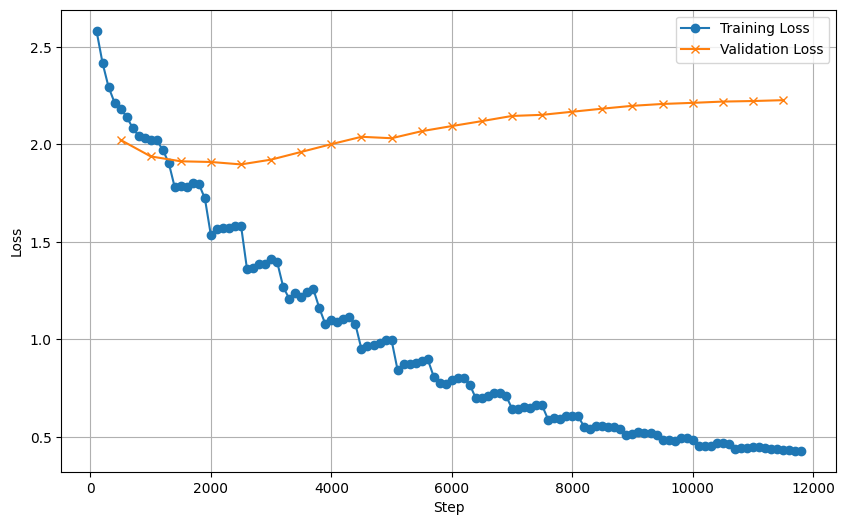

In [5]:
# 1. Load config from YAML
with open("../File_Yaml/Esecuzione_DAPT_10K.yaml", "r") as f:
    config = yaml.safe_load(f)

# 2. Load dataset
df = pd.read_csv(config["data_path"])
converted_columns = ["input_ids","attention_mask"]

df_val = pd.read_csv(config["data_path_val"])



for col in converted_columns :
    df[col] = df[col].apply(ast.literal_eval)
    df_val[col] = df_val[col].apply(ast.literal_eval)


# 3. Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained(config["tokenizer_name"])
model = BertForMaskedLM.from_pretrained(config["model_path"])

# 4. Data Preparation
prep = DataPreparation(df, tokenizer, max_length = config["max_length"])
mlm_encodings = prep.tokenize_and_segment_abstracts()
mlm_encodings = prep.apply_bert_masking(mlm_encodings)

masked = prep.masking_stats["masked_tokens"]
total = prep.masking_stats["total_tokens"]
percent = 100 * masked / total if total > 0 else 0

print(f"\n Percentage of masked tokens: {percent:.2f}% "
      f"({masked} on {total} valid tokens)")

# 5. Dataset
dataset = CombinedMLMNSPDataset(mlm_encodings)

prep_val = DataPreparation(df_val, tokenizer, max_length = config["max_length"])
mlm_encodings_val = prep_val.tokenize_and_segment_abstracts()
mlm_encodings_val = prep_val.apply_bert_masking(mlm_encodings_val)

dataset_val = CombinedMLMNSPDataset(mlm_encodings_val)
val_dataloader = torch.utils.data.DataLoader(dataset_val, batch_size=config["batch_size"], shuffle=False)

# 6. Trainer
trainer = DAPTTrainer(
    model=model,
    dataset=dataset,
    batch_size=config["batch_size"],
    epochs=config["epochs"],
    lr=config["learning_rate"],
    #checkpoint_interval=config["checkpoint_interval"],
    plot_save_path = config["plot_save_path"]
)

# 7. Training with timing
start_time = time.time()
trainer.train(
    log_every_n_steps=100,  # o quello che preferisci
    save_loss_path=os.path.join(config["checkpoint_dir"], "losses_stepwise.json"),
    val_dataloader=val_dataloader,      
    val_every_n_steps=500 
)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"\nTotal training time: {elapsed_time:.2f} seconds ({elapsed_time / 60:.2f} minutes)")


# 8. Save model and tokenizer
save_path = config["output_model_path"]  
os.makedirs(save_path, exist_ok=True)

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"Model and tokenizer saved to: {save_path}")